<a href="https://colab.research.google.com/github/MitaliThorat1316/Twitter-Sentiment-Analysis/blob/main/Bert_%26_roBERTa_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing and Importing dependencies**

In [ ]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

#!pip install transformers


In [ ]:
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')  # optional, provides additional WordNet information
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score, accuracy_score
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification
from transformers import BertTokenizer, BertModel
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import torch.nn.functional as F

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Changing device to GPU**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


**Load dataset**

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/training.1600000.processed.noemoticon.csv',
                    encoding='ISO-8859-1',
                    names = ['sentiment','ids','date', 'flag', 'user', 'tweet'])

**Dataset Analysis**

In [ ]:
df

,sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
df.loc[:, 'sentiment'] = df['sentiment'].replace(4, 1)
df

,sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
data=df[['tweet','sentiment']]

data_pos = data[data['sentiment'] == 1]
data_neg = data[data['sentiment'] == 0]

data_1 = data_pos.iloc[:int(20000)]
data_2 = data_neg.iloc[:int(20000)]

dataset = pd.concat([data_1, data_2])

dataset

,tweet,sentiment
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1
...,...,...
19995,"Not much time off this weekend, work trip to M...",0
19996,One more day of holidays,0
19997,feeling so down right now .. i hate you DAMN H...,0
19998,"geez,i hv to READ the whole book of personalit...",0


**Splitting the data into training and testing**

In [ ]:
# Separating the 80% data for training data and 20% for testing data
x_train, x_test, y_train, y_test = train_test_split(dataset.tweet, dataset.sentiment, test_size = 0.2, stratify=dataset.sentiment, random_state =42)

Training Set Class Distribution:
Class 0: 16000 samples
Class 1: 16000 samples

Testing Set Class Distribution:
Class 0: 4000 samples
Class 1: 4000 samples


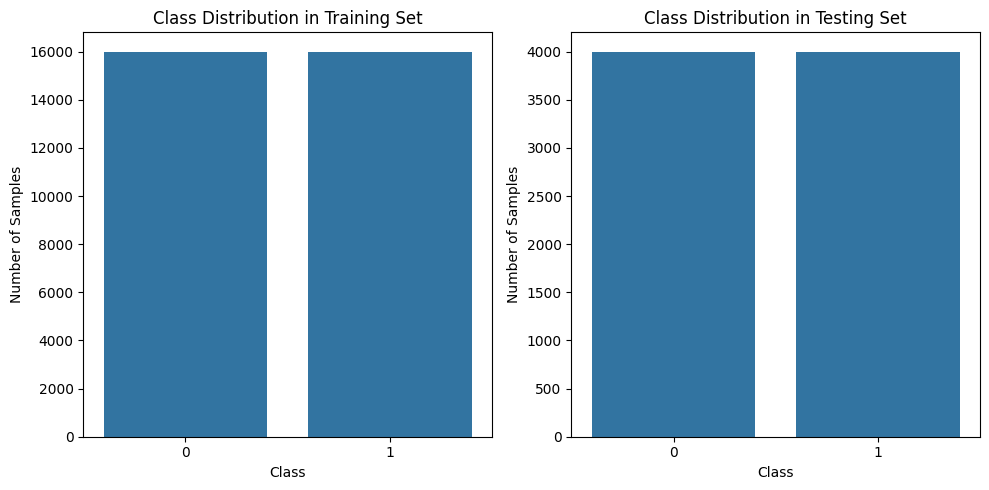

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each class in y_train and y_test
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

# Display the counts
print("Training Set Class Distribution:")
for label, count in zip(unique_train, counts_train):
    print(f"Class {label}: {count} samples")

print("\nTesting Set Class Distribution:")
for label, count in zip(unique_test, counts_test):
    print(f"Class {label}: {count} samples")

# Plotting the distribution for training set
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=unique_train, y=counts_train)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

# Plotting the distribution for testing set
plt.subplot(1, 2, 2)
sns.barplot(x=unique_test, y=counts_test)
plt.title('Class Distribution in Testing Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.show()


**Tokenization**

In [ ]:
# Load the BERT tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_tokens = tokenizer.batch_encode_plus(x_train.tolist(),
                                           max_length = 375,
                                           padding=True,
                                           truncation=True,
                                           return_tensors = 'pt')

val_tokens = tokenizer.batch_encode_plus(x_test.tolist(),
                                         max_length = 375,
                                         padding=True,
                                         truncation=True,
                                         return_tensors = 'pt')

In [ ]:
train_tokens

{'input_ids': tensor([[  101,  7632,  9468,  ...,     0,     0,     0],
        [  101,  1030,  9092,  ...,     0,     0,     0],
        [  101,  4365, 22794,  ...,     0,     0,     0],
        ...,
        [  101,  2145,  4586,  ...,     0,     0,     0],
        [  101,  4930,  2011,  ...,     0,     0,     0],
        [  101,  8299,  1024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

**Encoding**

In [ ]:
#train set
train_ids = train_tokens['input_ids']
train_masks = train_tokens['attention_mask']
train_label = torch.tensor(y_train.tolist())

#test set
val_ids = val_tokens['input_ids']
val_masks = val_tokens['attention_mask']
val_label = torch.tensor(y_test.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(train_ids,
                           train_masks,
                           train_label)

val_data = TensorDataset(val_ids,
                         val_masks,
                         val_label)

**Set Up BERT Pretrained Model**

In [ ]:
from transformers import BertForSequenceClassification

#load pre-trained BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 2,
                                                      output_attentions = False,
                                                      output_hidden_states = False)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

**Create Data Loaders**

In [ ]:
train_loader = DataLoader(train_data,
                          batch_size = 16,
                          shuffle = True)

val_loader = DataLoader(val_data,
                        batch_size = 16,
                        shuffle = True)

**Set Up Optimizer and Scheduler**

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
epochs = 10

#Load optimizer
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 1e-5,
                  eps = 1e-8)
#load scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(train_loader)*epochs)



**Define Performance Metrics**

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

#f1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [ ]:
# Overall accuracy function
def accuracy_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [ ]:
def evaluate(val_loader):

    #evaluation mode disables the dropout layer
    model.eval()

    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(val_loader):

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():
            outputs = model(**inputs)

        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    #compute average loss
    loss_val_avg = loss_val_total/len(val_loader)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

**Train Model**

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Initialize lists to store loss values
train_losses = []
val_losses = []

for epoch in tqdm(range(1, epochs+1)):

    #set model in train mode
    model.train()

    #tracking variable
    loss_train_total = 0

    #set up progress bar
    progress_bar = tqdm(train_loader,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)

    for batch in progress_bar:
        #set gradient to 0
        model.zero_grad()

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        # Move model to GPU if not already there
        model.to(device)

        outputs = model(**inputs)
        loss = outputs[0] #output.loss
        loss_train_total +=loss.item()

        #backward pass to get gradients
        loss.backward()

        #clip the norm of the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        #update optimizer
        optimizer.step()

        #update scheduler
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    tqdm.write('\nEpoch {epoch}')

    #print training result
    loss_train_avg = loss_train_total/len(train_loader)
    train_losses.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')

    #evaluate
    val_loss, predictions, true_vals = evaluate(val_loader)
    val_losses.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')

    #f1 score
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'F1 Score (weighted): {val_f1}')

    #accuracy
    val_acc = accuracy_func(predictions, true_vals)
    tqdm.write(f'Accuracy: {val_acc}')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.4214860139898956


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.3733737614750862
F1 Score (weighted): 0.8347995214501049
Accuracy: 0.834875


Epoch 2:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.30920851196628063


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.40059405253827574
F1 Score (weighted): 0.8382159849108275
Accuracy: 0.83825


Epoch 3:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.2247737879799679


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.4960794388204813
F1 Score (weighted): 0.8326146194910119
Accuracy: 0.832625


Epoch 4:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.16964953180553857


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.6611797927906736
F1 Score (weighted): 0.8300644578078511
Accuracy: 0.830125


Epoch 5:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.12540595409198432


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.8367336491614115
F1 Score (weighted): 0.8289848718072257
Accuracy: 0.829125


Epoch 6:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.09002525989236893


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.9138644386061933
F1 Score (weighted): 0.8279069729630724
Accuracy: 0.828


Epoch 7:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.06729661391756964


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.983916040896438
F1 Score (weighted): 0.8287004944428941
Accuracy: 0.82875


Epoch 8:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.05329093772183114


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 1.0781303927893169
F1 Score (weighted): 0.8334997398433436
Accuracy: 0.8335


Epoch 9:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.042010933761484924


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 1.1327250583858985
F1 Score (weighted): 0.8292714718210922
Accuracy: 0.829375


Epoch 10:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.03453226807563624


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 1.169630356195441
F1 Score (weighted): 0.8301213661898487
Accuracy: 0.830125


**Evaluation**

In [ ]:
# Get predictions for the validation set
_, predictions, true_vals = evaluate(val_loader)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(true_vals, predicted_labels)
print(report)


  0%|          | 0/500 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4000
           1       0.83      0.83      0.83      4000

    accuracy                           0.83      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.83      0.83      0.83      8000



  0%|          | 0/500 [00:00<?, ?it/s]

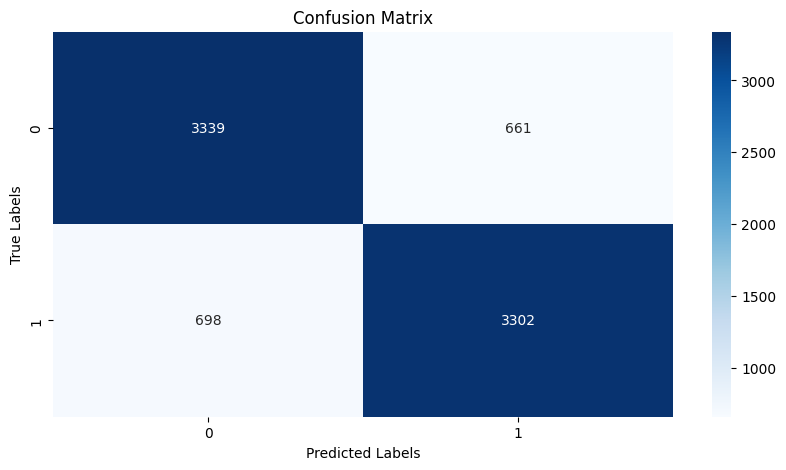

In [ ]:
val_loss, predictions, true_vals = evaluate(val_loader)  # Get predictions
preds_flat = np.argmax(predictions, axis=1).flatten()  # Flatten predictions

# Generate confusion matrix
cm = confusion_matrix(true_vals, preds_flat)

# Plot the confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


**Sentiment** **Analysis** **using** **RoBERTa**

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer_roberta = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.to(device)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
def tokenize_data(texts, max_length=375):
    return tokenizer_roberta.batch_encode_plus(
        texts.tolist(),
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )

train_tokens = tokenize_data(x_train)
val_tokens = tokenize_data(x_test)

In [ ]:
train_tokens

{'input_ids': tensor([[    0,   725, 31974,  ...,     1,     1,     1],
        [    0,  1039,   565,  ...,     1,     1,     1],
        [    0, 15177,   282,  ...,     1,     1,     1],
        ...,
        [    0, 31133,  1958,  ...,     1,     1,     1],
        [    0,  5320, 20777,  ...,     1,     1,     1],
        [    0,  8166,   640,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
# Create datasets
train_data = TensorDataset(train_tokens['input_ids'],
                           train_tokens['attention_mask'],
                           torch.tensor(y_train.tolist()))

val_data = TensorDataset(val_tokens['input_ids'],
                         val_tokens['attention_mask'],
                         torch.tensor(y_test.tolist()))

In [ ]:
# Create data loaders
batch_size = 16
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_data,
                        batch_size=batch_size,
                        shuffle=False)

In [ ]:
# Set up optimizer and scheduler
epochs = 5

optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

#f1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

# Overall accuracy function
def accuracy_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)


In [ ]:
def evaluate(val_loader):

    #evaluation mode disables the dropout layer
    model.eval()

    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(val_loader):

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():
            outputs = model(**inputs)

        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    #compute average loss
    loss_val_avg = loss_val_total/len(val_loader)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Initialize lists to store loss values
train_losses = []
val_losses = []

for epoch in tqdm(range(1, epochs+1)):

    #set model in train mode
    model.train()

    #tracking variable
    loss_train_total = 0

    #set up progress bar
    progress_bar = tqdm(train_loader,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)

    for batch in progress_bar:
        #set gradient to 0
        model.zero_grad()

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        # Move model to GPU if not already there
        model.to(device)

        outputs = model(**inputs)
        loss = outputs[0] #output.loss
        loss_train_total +=loss.item()

        #backward pass to get gradients
        loss.backward()

        #clip the norm of the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        #update optimizer
        optimizer.step()

        #update scheduler
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    tqdm.write('\nEpoch {epoch}')

    #print training result
    loss_train_avg = loss_train_total/len(train_loader)
    train_losses.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')

    #evaluate
    val_loss, predictions, true_vals = evaluate(val_loader)
    val_losses.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')

    #f1 score
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'F1 Score (weighted): {val_f1}')

    #accuracy
    val_acc = accuracy_func(predictions, true_vals)
    tqdm.write(f'Accuracy: {val_acc}')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.3511417817790061


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.30478112752363085
F1 Score (weighted): 0.87696665416151
Accuracy: 0.877125


Epoch 2:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.2381469890186563


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.33399904815480114
F1 Score (weighted): 0.8802769000142757
Accuracy: 0.880375


Epoch 3:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.16647680303925882


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.5498092415856664
F1 Score (weighted): 0.8813749536620912
Accuracy: 0.881375


Epoch 4:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.1079473619532073


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.660853162077372
F1 Score (weighted): 0.8785682135634959
Accuracy: 0.878625


Epoch 5:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.07312045656953706


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss: 0.7214733074180549
F1 Score (weighted): 0.8766235946656329
Accuracy: 0.876625


  0%|          | 0/500 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      4000
           1       0.87      0.88      0.88      4000

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



  0%|          | 0/500 [00:00<?, ?it/s]

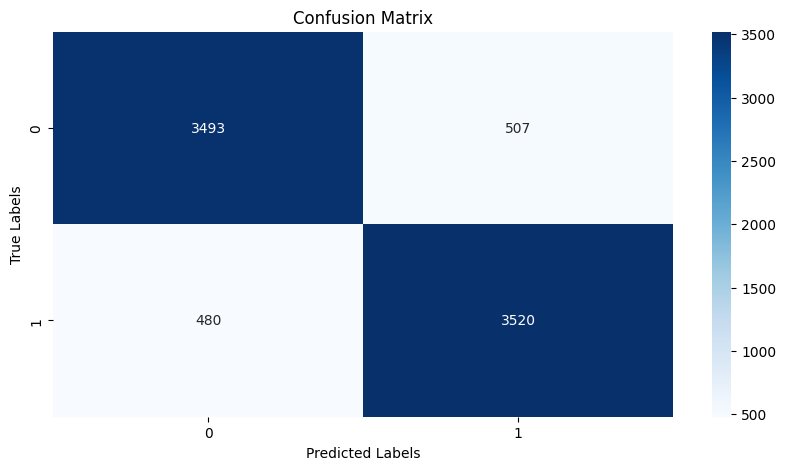

In [ ]:
# Get predictions for the validation set
_, predictions, true_vals = evaluate(val_loader)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(true_vals, predicted_labels)
print(report)

val_loss, predictions, true_vals = evaluate(val_loader)  # Get predictions
preds_flat = np.argmax(predictions, axis=1).flatten()  # Flatten predictions

# Generate confusion matrix
cm = confusion_matrix(true_vals, preds_flat)

# Plot the confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
